# Assignment — Multi-hop Reasoning on Knowledge graphs

Knowledge graph embedding allows predicting missed links in the graph. However, it does not allow to answer of complex logical queries.

For example, one can want to answer `Where did Canadian citizens with Turing Award graduate?`. Such question can be decomposed into several smaller questions and construct DAG (directed acyclic graph) of logical operations.


![test](http://snap.stanford.edu/query2box/model.png)

_reference: http://snap.stanford.edu/query2box/_

We will use implementations of models from https://github.com/snap-stanford/KGReasoning

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchkge import KnowledgeGraph
from torchkge.utils import Trainer
from torchkge.models.bilinear import RESCALModel
from torchkge.utils import MarginLoss
import requests
import pandas as pd
import numpy as np
from zlib import adler32
from tqdm.notebook import trange

### Task 1. Beam-search with TransE (1 point)

Beam-search is a technique of generating most probable sequences.

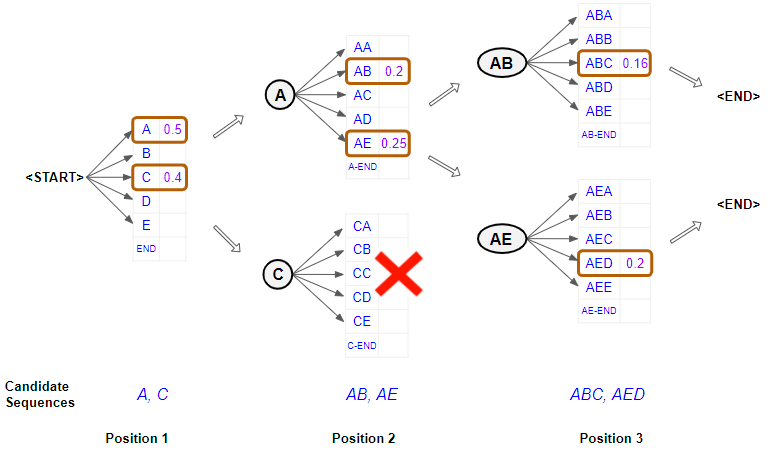![](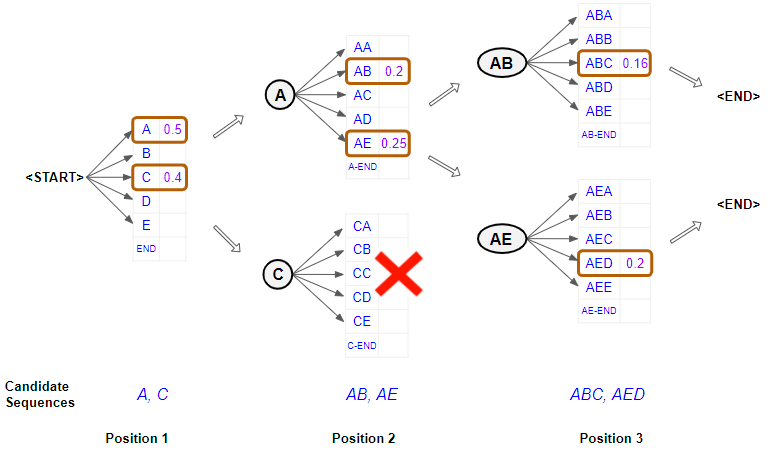https://www.google.com/url?sa=i&url=https%3A%2F%2Ftowardsdatascience.com%2Ffoundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24&psig=AOvVaw0M64q0sVqKPdS9UgPCyyFQ&ust=1622042812171000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCKig2L6S5fACFQAAAAAdAAAAABAD)

It works as follows:
1. Start from some root (`<START>` token on image)
2. Predict subsequent tokens
3. Select `k` most probable subsequences from generated
4. Repeat the procedure

In the current task, we will apply it to the query represented in the sequential form.

We will work with the queries that can be represented in conjunctive normal form. For example, we have a query `What country was replaced by Canada neighbours`. `Canada neighbors` can be found by prediction tail `t` for query `h = "Canada"`, `r = "shares border with"`. And `What country was replaced by` could be represented as a tail for query `h = t`, `r = "replaces"`.

So our query can be decomposed into two smaller ones.

Let us download the dataset from the previous seminar.

In [ ]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_edges.tsv'
open('countries_edges.tsv', 'wb').write(requests.get(url).content)
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_entities.tsv'
open('countries_entities.tsv', 'wb').write(requests.get(url).content)
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_relations.tsv'
open('countries_relations.tsv', 'wb').write(requests.get(url).content);


edges = pd.read_csv('countries_edges.tsv', sep='	').values
entity_labels = pd.read_csv('countries_entities.tsv', sep='	', index_col=0).label.values
relation_labels = pd.read_csv('countries_relations.tsv', sep='	', index_col=0).label.values

edges_labeled = np.stack([entity_labels[edges[:, 0]], 
                          entity_labels[edges[:, 1]], 
                          relation_labels[edges[:, 2]]], axis=1)

df = pd.DataFrame(edges_labeled, columns=['h', 't', 'r'])[['h', 'r', 't']]
df.head()

Firstly, we need to check the answer in the given dataset.

In [ ]:
neighbors = set(df[(df.h == 'Canada') & (df.r == "shares border with")].t)

In [ ]:
def find_replaces(df):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
el = find_replaces(df).pop()
assert adler32(el.encode()) == 2730560188
print(el)

We can find an answer in our dataset, but for complex queries or incomplete graphs, such a task could be very hard. So we can work with knowledge graph embedding models to solve it.

Firstly, let us initialize the knowledge graph dataset from torchkge.

In [ ]:
kg = KnowledgeGraph(pd.DataFrame(edges_labeled, columns=['from', 'to', 'rel']))

Secondly, we need to train the fine embedding model. We will use `RESCALModel` from torchkge. Similarly to the TransE model from the previous seminar, it learns two embedding tensors. However, instead of embed relations, it learns the projection matrix for each relation.

In [ ]:
model = RESCALModel(128, kg.n_ent, kg.n_rel)
criterion = MarginLoss(margin=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(
    model, criterion, kg, n_epochs=250, 
    batch_size=2048, optimizer=optimizer)

In [ ]:
trainer.run()

After the model trained, we need to find the top k most similar tails to our head and relation.

You need to define the `find_most_similar` function that takes our trained model, knowledge graph, head and relation from a query in string form and the number of most similar items to return.

It works as follows:

1. Extract embeddings from the model using `get_embeddings` method
2. Extract vector for head
3. Extract matrix for relation
4. Calculate predicted embedding for tail via torch.matmull over head vector and relation matrix
5. Normalize predicted vector
6. Calculate cosine similarity between predicted embedding and each entity from entity embedding matrix (normalize dot product + 1 / 2)
7. Return np.array with indices of the top k most similar entities and np.array with corresponding values sorted in descending order

In [ ]:
def find_most_similar(model, kg, head, relation, k):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
ids, sims = find_most_similar(model, kg, "Canada", "shares border with", 5)
assert len(ids) == 5
assert ((sims[:-1] - sims[1:]) >= 0).mean() == 1

Now we can try to answer our query in two steps.

In [ ]:
# 1
ids, sims = find_most_similar(model, kg, "Canada", "shares border with", 5)

# 2
ix2ent = {j: i for i, j in kg.ent2ix.items()}
results = []
for i in ids:
    idx, s = find_most_similar(model, kg, ix2ent[i], "replaces", 5)
    score_matrix = np.outer(sims, s).flatten()
    topk = score_matrix.argsort()[-5:]
    results.extend(zip(ids[topk // 5], idx[topk % 5], score_matrix[topk]))
results_topk = sorted(results, key=lambda x: x[2])[-5:]
results_topk_entities = [ix2ent[j] for _, j, _ in results_topk]

assert 2730560188 in [adler32(i.encode()) for i in results_topk_entities]
print('\n'.join(results_topk_entities))

### Task 2. [Graph query embedding](https://arxiv.org/abs/1806.01445) (2 points)

In the previous task we use the several projection steps. It is a analogue of existential quantification in the vector space.

Graph Query Embedding also allow to handle conjunction between different statements. For example, we may want to answer question `What country Russia and Canada share border with?`.

This statement could be decomposed to the statement. `Russia shares border with` & `Canada shares border with`.

The GQE models the projection using translation operator (similarly to TransE) and [DeepSets](https://arxiv.org/abs/1703.06114) to model conjunction. The intersection operator works in several steps:
1. We pass individual element embeddings through the feed-forward neural network.
2. We aggregate the result of model inference using a symmetric operator (e.g. mean, sum).
3. Transform it using a projection matrix.

Let us download the realized models from https://github.com/snap-stanford/KGReasoning.

In [ ]:
url = 'https://raw.githubusercontent.com/snap-stanford/KGReasoning/main/models.py'
with open("models.py", "wb") as f:
    f.write(requests.get(url).content)
    
url = 'https://raw.githubusercontent.com/snap-stanford/KGReasoning/main/dataloader.py'
with open("dataloader.py", "wb") as f:
    f.write(requests.get(url).content)
    
url = 'https://raw.githubusercontent.com/snap-stanford/KGReasoning/main/util.py'
with open("util.py", "wb") as f:
    f.write(requests.get(url).content)


In [ ]:
import models

Firstly, we need to define what types of queries we will prefer to handle.

1. `1p` is one projection (both models)
2. `2p` is two sequential projections (both models)
3. `2u-DNF` is a disjunctive normal form, i.e. union (disjunction) between two `1p` queries (Q2B)

In [ ]:
query_name_dict = {
    ('e',('r',)): '1p', 
    ('e', ('r', 'r')): '2p',
    (('e', ('r',)), ('e', ('r',))): '2i',
    (('e', ('r',)), ('e', ('r',)), ('u',)): '2u-DNF',
}

Before model training, we need to generate datasets for it.

You need to implement two functions, `generate_queries` and `generete_queries_conjunction`.

The first one generates one- and two-hop queries and answers. It takes df with hrt triplets, mapping from text entity to ids (`kg.ent2ix`), mapping from text relation to ids (`kg.rel2ix`). And it should return the list with triplets in the form of query type and the mapping of answers. Answers are constructed as a python dictionary where keys are queries and value is a set of possible tails to answer the given query.

E.g. if we have a query of type `1p` the sample should look like `(187, (41,))`. Similarly, for `2i` query: `(187, (41,), (1342, (41,)))`.

The answer for this queries should look like:

```
{
    (187, (41,)): {345, 588, 1666},
    (187, (41,), (1342, (41,))): {1666}
}
```

Firstly, you need to convert heads, relations and tails by corresponding ids.

Then, you need to calculate one-hop queries. One-hop queries could be calculated by group by over data frame (`df.groupby(['h','r']).t.agg(set)`)

Finally, you need to find two-hop relations. We can join the data frame on itself left_on `t` and right_on `h`. Now, the data frame should be grouped by `h_x`, `r_x` and `r_y`.

In [ ]:
def generate_queries(df, ent2id, rel2id):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
train_queries, train_answers = generate_queries(df, kg.ent2ix, kg.rel2ix)
assert train_queries[0][1] in [(('e', ('r',))), ('e', ('r', 'r'))]
assert ((187, (41,)), ('e', ('r',))) in train_queries
assert adler32(' '.join([str(i) for i in sorted(list(train_answers[(187, (41,))]))]).encode()) == 252052053

Also, we want to generate some intersection (conjunction) examples of type `2i` with `generate_queries_conjunction`.

Intersection result of two projection relations could be achieved by joining the data frame with itself on `t` column because intersection means coincidental result.

`generate_queries_conjunction` works similarly to `generate_queries` but should find intersection queries. 

In [ ]:
def generate_queries_conjunction(df, ent2id, rel2id):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
train_queries_conj, train_answers_conj = generate_queries_conjunction(df, kg.ent2ix, kg.rel2ix)
assert train_queries_conj[0][1] == (('e', ('r',)), ('e', ('r',)))
assert (((1808, (6,)), (1084, (12,))), (('e', ('r',)), ('e', ('r',)))) in train_queries_conj
assert train_answers_conj[((1808, (6,)), (1084, (12,)))] == {1666}

We can merge both train samples.

In [ ]:
train_queries.extend(train_queries_conj)
train_answers.update(train_answers_conj)

Now we are ready to instantiate the GQE model using the `KGReasoning` wrapper. The `geo` argument defines what model to use: `vec` is a GQE, `box` is a Query2Box, `betae` is a BetaE model.

In [ ]:
cqe_model = models.KGReasoning(
    nentity=kg.n_ent,
    nrelation=kg.n_rel,
    hidden_dim=800,
    gamma=24,
    geo="vec",
    use_cuda=False,
    box_mode=None,
    beta_mode=None,
    test_batch_size=128,
    query_name_dict=query_name_dict
)

Optimizer to train it

In [ ]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, cqe_model.parameters()), 
    lr=0.001
)

Dataset iterator

In [ ]:
from torch.utils.data import DataLoader
from dataloader import TestDataset, TrainDataset, SingledirectionalOneShotIterator

train_path_iterator = SingledirectionalOneShotIterator(DataLoader(
    TrainDataset(train_queries, kg.n_ent, kg.n_rel, 128, train_answers),
    batch_size=512,
    shuffle=True,
    num_workers=4,
    collate_fn=TrainDataset.collate_fn
))

Let us mock-up CLI arguments

In [ ]:
class Args:
    print_on_screen = True
    cuda = False
    test_batch_size = 1
    test_log_steps = 10
args = Args()

And train model

In [ ]:
for i in trange(50):
    cqe_model.train_step(cqe_model, optimizer, train_path_iterator, args,i)

To predict results, we need to define the `predict_kg_reasoning` function.

The input is our trained model, torchkge knowledge graph, flatten query and its type.

Flatten query is a flat list with ids, without query_type structure, e.g. `[1342, 41, 187, 41]`

We will use the native model.forward function. It takes several arguments: positive_sample, negative_sample, subsampling_weight, batch_queries_dict, batch_idxs_dict. The positive_sample and subsampling_weight is None.

The negative sample is constructed as array of all entity ids with the shape `(1, number of entities)`.


After, you need to construct batch_queries_dict -- a mapping from query type to query wrapped with torch.tensor of shape `(1, len(flatten_query))`.

Then, you need to construct batch_idxs_dict -- a mapping from query_type to indices of corresponding queries. Here we have only one index so that it will be a `{query_type: [0]}`.

Now, you can pass it to the `model.forward` function and receive `positive_logit, negative_logit, subsampling_weight, batch_ids`. However, we are only interested in the `negative_logit`.

Negative logit is our score of how close each entity is to our answer. To choose the best entity ids, we need to argsort our negative_logit and take top k.

Finally, you need to convert entity

In [ ]:
def predict_kg_reasoning(model, kg, flatten_query, query_type, k=5, ix2ent=ix2ent):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
ans = predict_kg_reasoning(cqe_model, kg, [kg.ent2ix['Russia'], kg.rel2ix['shares border with'], kg.ent2ix['Canada'], kg.rel2ix['shares border with']], (('e', ('r', )), ('e', ('r', ))))
assert 1847527621 in [adler32(i.encode()) for i in ans]
print('\n'.join(ans))

### Task 3. [Query2Box](http://snap.stanford.edu/query2box/) (7 points)

Query2Box additionally allow to model union (disjunction) queries.


The general idea of Query2Box is to model sets as boxes. If an entity is in the set, then the corresponding embedding should lie inside the query box. The box is defined by the vector of centre and offset.

The projection (existential operator) works similarly to the translation models: the model sums the centres and offsets.
The intersection of the boxes could be found by performing attention over box queries. Offsets are calculated using DeepSets over the boxes and are shrunk with the sigmoid function.

A simple geometric union of the boxes could be a bad idea because query boxes could lie in different places of our space. So, before doing union, the authors propose transforming our query to the disjunctive normal form (DNF).
It allows to perform all box logic with projection and intersection operators and, finally, found the best entities close to one of the resulting boxes.

![test](http://snap.stanford.edu/query2box/dnf.png)


Before we train the model, we need to generate the disjunctive examples to it.

We will generate union pairs only for relation type `shares border with`.
`generate_queries_disjunction` takes the data frame with triplets, entity to index converter, relation to index converter, number of elements in subsample and random_state for sampling.

1. Generate one-hop queries
2. Generate two samples from step 1 using `df.sample(n, random_state=random_state)`
3. zip one-hop queries and construct union query (e.g. `((187, (41, )), (1071, (41, )), (-1,))`)
4. construct answers as unions of answers for one-hop queries

In [ ]:
def generate_queries_disjunction(df, ent2id, rel2id, n, random_state=0):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
train_queries_dis = []
train_answers_dis = {}
for i in trange(500):
    tq, ta = generate_queries_disjunction(df, kg.ent2ix, kg.rel2ix, 300, random_state=2 * i)
    train_queries_dis.extend(tq)
    train_answers_dis.update(ta)

In [ ]:
assert train_queries_dis[0][1] == (('e', ('r',)), ('e', ('r',)), ('u',))
assert (((129, (41,)), (1706, (41,)), (-1,)), (('e', ('r',)), ('e', ('r',)), ('u',))) in train_queries_dis
assert sum(train_answers_dis[(((129, (41,)), (1706, (41,)), (-1,)))]) == 2267

Initialize model, optimizer and train iterator.

In [ ]:
q2b_model = models.KGReasoning(
    nentity=kg.n_ent,
    nrelation=kg.n_rel,
    hidden_dim=800,
    gamma=24,
    geo="box",
    use_cuda=False,
    box_mode=('relu', 0.05),
    beta_mode=None,
    test_batch_size=128,
    query_name_dict=query_name_dict
)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, q2b_model.parameters()), 
    lr=0.01
)

train_path_iterator = SingledirectionalOneShotIterator(DataLoader(
    TrainDataset(train_queries_dis, kg.n_ent, kg.n_rel, 128, train_answers_dis),
    batch_size=512,
    shuffle=True,
    num_workers=4,
    collate_fn=TrainDataset.collate_fn
))

Now, we will try to answer the question `What countries share a border with Canada or Mexico?`.

In [ ]:
set(df[(df.h == 'Mexico') & (df.r == 'shares border with')].append(df[(df.h == 'Canada') & (df.r == 'shares border with')]).t)

In [ ]:
for i in trange(50):
    q2b_model.train_step(q2b_model, optimizer, train_path_iterator, args,i)

In [ ]:
ans = predict_kg_reasoning(
    q2b_model,
    kg,
    [kg.ent2ix['Canada'], kg.rel2ix['shares border with'], kg.ent2ix['Mexico'], kg.rel2ix['shares border with'], -1],
    (('e', ('r',)), ('e', ('r',)), ('u',)), k=10, ix2ent=ix2ent)
hashed = [adler32(i.encode()) for i in ans]
assert 1847527621 in hashed
assert 1897990456 in hashed
assert 131007068 in hashed
assert 295175058 in hashed
assert 292684689 in hashed
print('\n'.join(ans))